### TFIDF + popular classifiers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

import string

In [2]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, accuracy_score
from tqdm import tqdm

fix_seed = 42

In [3]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def get_train_val_test_split(X, y):
    X_train = X[X['subset'] == 'train']
    y_train = y[X['subset'] == 'train']
    
    X_val = X[X['subset'] == 'val']
    y_val = y[X['subset'] == 'val']
    
    X_test = X[X['subset'] == 'test']
    y_test = y[X['subset'] == 'test']
    
    X_train = X_train.drop('subset', axis=1)
    X_val = X_val.drop('subset', axis=1)
    X_test = X_test.drop('subset', axis=1)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [4]:
textual_dataset_original = pd.read_csv('textual_data_version6_original.csv')
textual_dataset_oversampled = pd.read_csv('textual_data_version6_oversampled.csv')
    
textual_dataset_original.shape, textual_dataset_oversampled.shape

((4466, 6), (7214, 6))

In [5]:
def preprocess_and_get_X_y(dataset):
    dataset['text'] = dataset['text'].apply(preprocess_text)
    X = dataset.drop(['cik', 'ticker', 'label', 'report_datetime'], axis=1)
    y = dataset['label']
    
    return X, y

def get_subsets(_X, _y, concat_train_and_test=True):
    X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test_split(_X, _y)
    
    X_train = X_train['text']
    X_val = X_val['text']
    X_test = X_test['text']
    
    if concat_train_and_test:
        X_train_val = pd.concat([X_train, X_val])
        y_train_val = pd.concat([y_train, y_val])
        
        print(f"X_train_val shape: {X_train_val.shape}")
        print(f"X_test shape: {X_test.shape}")
        
        return X_train_val, y_train_val, X_test, y_test

    print(f"X_train shape: {X_train.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"X_test shape: {X_test.shape}")
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [18]:
def get_classifiers(random_state=43):
    randomForestClassifier = RandomForestClassifier(random_state=random_state)
    gradientBoostingClassifier = GradientBoostingClassifier(random_state=random_state)
    adaBoostClassifier = AdaBoostClassifier(random_state=random_state, algorithm='SAMME')
    extraTreesClassifier = ExtraTreesClassifier(random_state=random_state)
    baggingClassifier = BaggingClassifier(random_state=random_state)
    logisticRegression = LogisticRegression(random_state=random_state, max_iter=300)
    svc = SVC(random_state=random_state)
    decisionTreeClassifier = DecisionTreeClassifier(random_state=random_state)
    kNeighborsClassifier = KNeighborsClassifier(weights='uniform', p=2, n_neighbors=7, leaf_size=10, algorithm='brute')
    gaussianNB = GaussianNB()
    mlpClassifier = MLPClassifier(hidden_layer_sizes=(16, 16),
                               batch_size=64,
                               max_iter=300,
                               shuffle=False,
                               random_state=random_state,
                               early_stopping=True,
                               beta_2=0.99,
                               n_iter_no_change=10)
    xgbClassifier = XGBClassifier(random_state=random_state)
    # 
    # return [xgbClassifier, randomForestClassifier, gradientBoostingClassifier, adaBoostClassifier, extraTreesClassifier, baggingClassifier, logisticRegression, svc, decisionTreeClassifier, kNeighborsClassifier, gaussianNB, mlpClassifier]
    return [kNeighborsClassifier]

In [19]:
X_original, y_original = preprocess_and_get_X_y(textual_dataset_original)
X_oversampled, y_oversampled = preprocess_and_get_X_y(textual_dataset_oversampled)

X_original_train, y_original_train, X_original_val, y_original_val, X_original_test, y_original_test =(
    get_subsets(X_original, y_original, concat_train_and_test=False))

X_oversampled_train, y_oversampled_train, X_oversampled_val, y_oversampled_val, X_oversampled_test, y_oversampled_test =( 
    get_subsets(X_oversampled, y_oversampled, concat_train_and_test=False))

datasets = [
    [X_original_train, X_original_test, y_original_train, y_original_test],
    [X_oversampled_train, X_oversampled_test, y_oversampled_train, y_oversampled_test]
]

X_train shape: (3563,)
X_val shape: (225,)
X_test shape: (678,)
X_train shape: (5760,)
X_val shape: (363,)
X_test shape: (1091,)


In [20]:
results = []

for X_train, X_test, y_train, y_test in datasets:
    
    results_tmp = {}
    
    vectorizer = TfidfVectorizer(max_features=1000)
    X_train_features = vectorizer.fit_transform(X_train)
    X_test_features = vectorizer.transform(X_test)

    for j in tqdm(range(5)):
        random_state = fix_seed + j
        classifiers = get_classifiers(random_state=random_state)
        
        for classifier in classifiers:
            classifier.fit(X_train_features, y_train)
            y_pred = classifier.predict(X_test_features)
            
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            
            classifier_name = classifier.__class__.__name__
            if classifier_name not in results_tmp:
                results_tmp[classifier_name] = [[accuracy, precision]]
            else:
                results_tmp[classifier_name].append([accuracy, precision])
                
            del classifier
                
    results_mean = {k: np.mean(v, axis=0) for k, v in results_tmp.items()}
    results_mean = [[k] + v.tolist() for k, v in results_mean.items()]
    results_df = pd.DataFrame(results_mean, columns=['classifier', 'accuracy', 'precision'])
    
    results.append(results_df)

100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


In [21]:
results[0]

,classifier,accuracy,precision
0,KNeighborsClassifier,0.985251,1.0


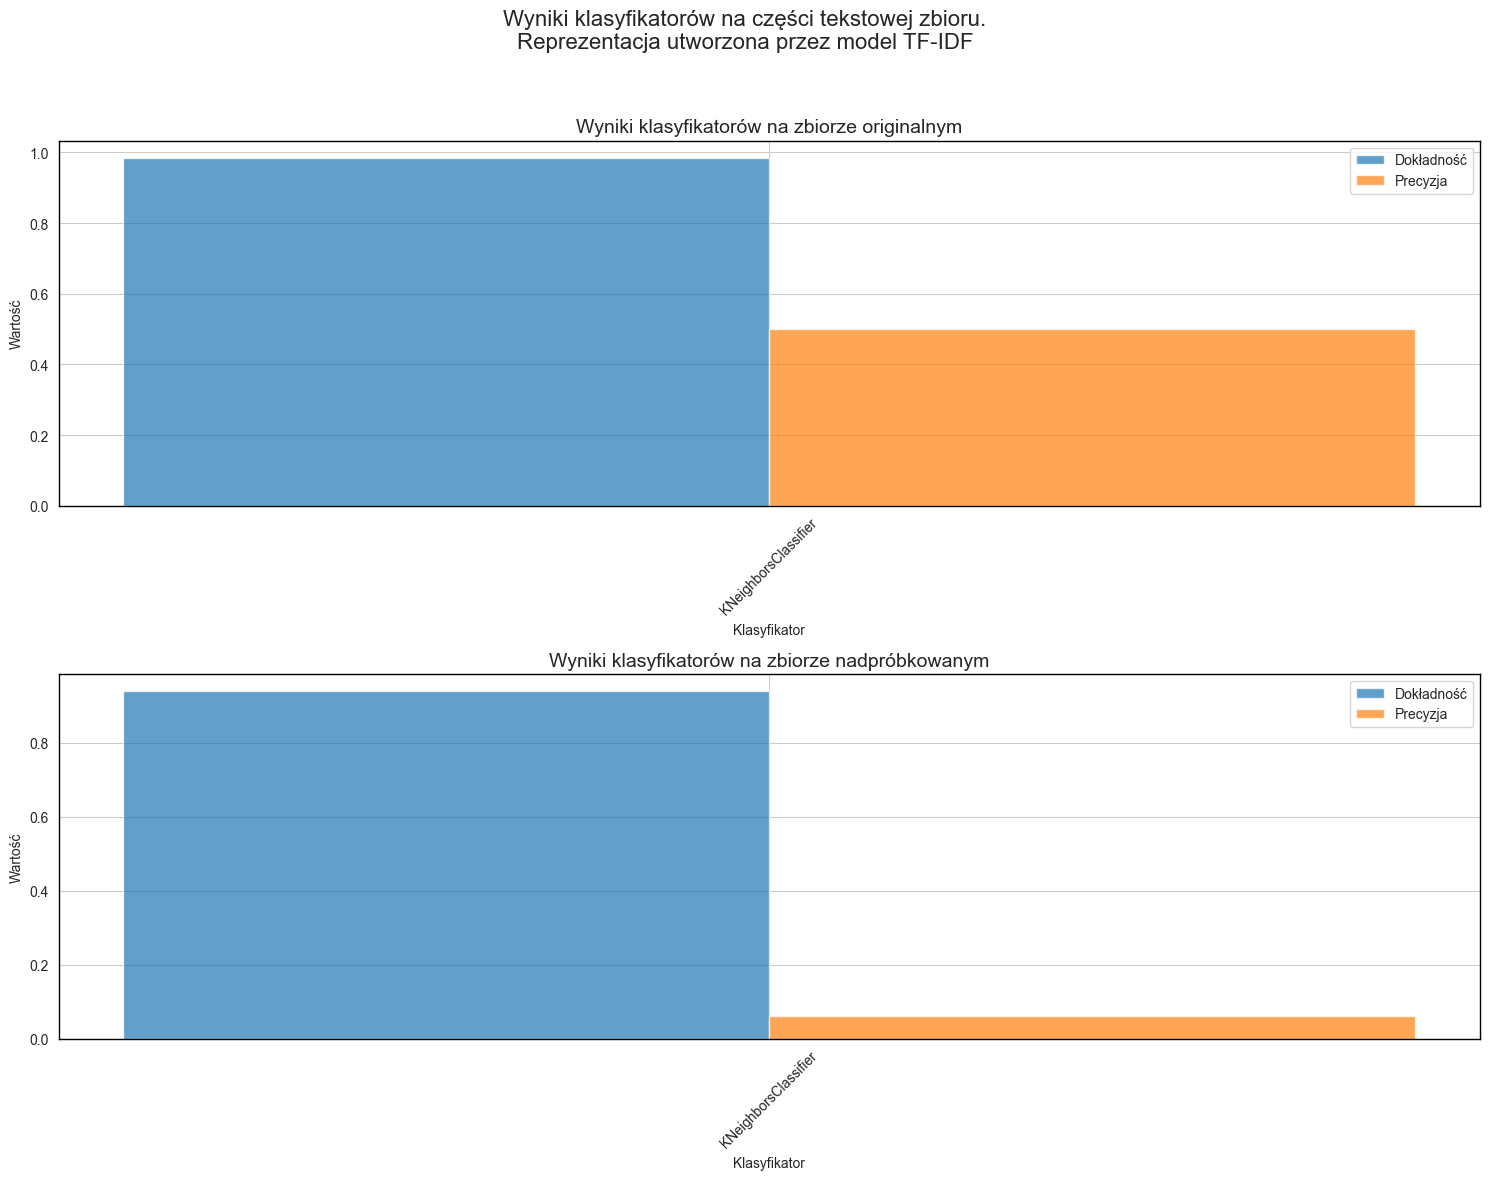

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(len(results), 1, figsize=(15, 6 * len(results)))

titles = ['Wyniki klasyfikatorów na zbiorze originalnym', 'Wyniki klasyfikatorów na zbiorze nadpróbkowanym']

fig.suptitle('Wyniki klasyfikatorów na części tekstowej zbioru.\nReprezentacja utworzona przez model TF-IDF', fontsize=16)

for i, df in enumerate(results):
    bar_width = 0.25
    bar_positions = np.arange(len(df['classifier']))
    
    axes[i].bar(bar_positions, df['accuracy'], bar_width, label='Dokładność', alpha=0.7)
    axes[i].bar(bar_positions + bar_width, df['precision'], bar_width, label='Precyzja', alpha=0.7)
    
    axes[i].set_title(f'{titles[i]}', fontsize=14)
    axes[i].set_xlabel('Klasyfikator')
    axes[i].set_ylabel('Wartość')
    axes[i].set_xticks(bar_positions + bar_width / 2)
    axes[i].set_xticklabels(df['classifier'], rotation=45)
    axes[i].legend()
    
for i, _ in enumerate(results):
    for spine in axes[i].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()


In [2]:
from investment_system.data_utils import get_multimodal_data
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

(X_numerical_train, y_numerical_train, X_numerical_val, y_numerical_val, X_numerical_test, y_numerical_test,
            X_textual_train, y_textual_train, X_textual_val, y_textual_val, X_textual_test, y_textual_test) = get_multimodal_data(drop_all_columns=True)

In [3]:
tf_idf_vectorizer = TfidfVectorizer(max_features=1000)

X_textual_train_features = tf_idf_vectorizer.fit_transform(X_textual_train['text'].values)
X_textual_val_features = tf_idf_vectorizer.transform(X_textual_val['text'].values)
X_textual_test_features = tf_idf_vectorizer.transform(X_textual_test['text'].values)

In [2]:
# tf_idf_vectorizer = TfidfVectorizer(max_features=1000)
# 
# X_textual_train_val_features = tf_idf_vectorizer.fit_transform(pd.concat([X_textual_train['text'], X_textual_val['text']]))
# y_textual_train_val = pd.concat([y_textual_train, y_textual_val])
# 
# X_textual_test_features = tf_idf_vectorizer.transform(X_textual_test['text'].values)

### RandomizedSearchCV for KNeighborsClassifier

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
import numpy as np

In [5]:
kNeighborsClassifier = KNeighborsClassifier()

# Define a hyperparameter grid
param_grid_kNeighborsClassifier = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2]
}

early_stopping_rounds = 10

grid_search = RandomizedSearchCV(
    estimator=kNeighborsClassifier, 
    param_distributions=param_grid_kNeighborsClassifier,
    n_iter=40,
    scoring='accuracy',
    n_jobs=1,
    verbose=1,
    random_state=42
)

grid_search.fit(X_textual_train_val_features, y_textual_train_val)

print("Best hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_textual_test_features)

test_accuracy = accuracy_score(y_textual_test, y_pred)
test_precision = precision_score(y_textual_test, y_pred)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")


Fitting 5 folds for each of 40 candidates, totalling 200 fits


C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptc

Best hyperparameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 11, 'leaf_size': 40, 'algorithm': 'kd_tree'}
Test Accuracy: 0.9838
Test Precision: 0.0000


C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best hyperparameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 7, 'leaf_size': 10, 'algorithm': 'kd_tree'}Best hyperparameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 7, 'leaf_size': 10, 'algorithm': 'kd_tree'}
Test Accuracy: 0.9853
Test Precision: 1.0000

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracies = []
precisions = []
recalls = []

random_state = 42

# vectorizer = TfidfVectorizer(max_features=1000)
# X_train_features = vectorizer.fit_transform(X_original_train_val)
# X_test_features = vectorizer.transform(X_original_test)

for i in tqdm(range(10)):
    
    kNeighborsClassifier = KNeighborsClassifier(weights='uniform', p=2, n_neighbors=7, leaf_size=10, algorithm='kd_tree')
    
    kNeighborsClassifier.fit(X_textual_train_features, y_textual_train)
    
    y_pred = kNeighborsClassifier.predict(X_textual_test_features)
    
    accuracy = accuracy_score(y_textual_test, y_pred)
    precision = precision_score(y_textual_test, y_pred)
    recall = recall_score(y_textual_test, y_pred)
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    
    # remove the classifier
    del kNeighborsClassifier
    
print(f"Mean Accuracy: {np.mean(accuracies)}")
print(f"Mean Precision: {np.mean(precisions)}")
print(f"Mean Recall: {np.mean(recalls)}")

    # print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
    # print(f"Test Precision: {precision_score(y_test, y_pred)}")
    # print(f"Test Recall: {recall_score(y_test, y_pred)}")

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
 10%|█         | 1/10 [00:00<00:01,  5.95it/s]C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
 20%|██        | 2/10 [00:00<00:01,  5.98it/s]C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


Accuracy: 0.9852507374631269
Precision: 1.0
Accuracy: 0.9852507374631269
Precision: 1.0


 30%|███       | 3/10 [00:00<00:01,  5.49it/s]C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
 40%|████      | 4/10 [00:00<00:01,  5.29it/s]

Accuracy: 0.9852507374631269
Precision: 1.0
Accuracy: 0.9852507374631269
Precision: 1.0


C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
 50%|█████     | 5/10 [00:00<00:00,  5.52it/s]C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
 60%|██████    | 6/10 [00:01<00:00,  5.86it/s]

Accuracy: 0.9852507374631269
Precision: 1.0
Accuracy: 0.9852507374631269
Precision: 1.0


C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
 70%|███████   | 7/10 [00:01<00:00,  5.91it/s]C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
 80%|████████  | 8/10 [00:01<00:00,  5.94it/s]C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


Accuracy: 0.9852507374631269
Precision: 1.0
Accuracy: 0.9852507374631269
Precision: 1.0


 90%|█████████ | 9/10 [00:01<00:00,  5.78it/s]C:\Users\grzeg\PycharmProjects\bankruptcy-prophet-new\bankruptcy-prophet\.venv\Lib\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
100%|██████████| 10/10 [00:01<00:00,  5.77it/s]

Accuracy: 0.9852507374631269
Precision: 1.0
Accuracy: 0.9852507374631269
Precision: 1.0
Mean Accuracy: 0.985250737463127
Mean Precision: 1.0
Mean Recall: 0.09090909090909091
